# MLB Analytics Pipeline

### Necessary Imports

In [114]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

import matplotlib.pyplot as plt
from matplotlib import cm 

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression

### HTML Formatting

In [115]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### Matplotlib Colors Class

In [116]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

# Data Scraping

### Web Scraping Team Data

#### 2022 Team Records Data

In [117]:
tables = pd.read_html('https://www.espn.com/mlb/standings/_/season/2022/group/overall')
df_standings = pd.concat([tables[0], tables[1]], axis=1)
df_standings[df_standings.columns[0]] = df_standings[df_standings.columns[0]].shift(1)
df_standings.iloc[0,0] = df_standings.columns[0]
df_standings = df_standings.rename(columns={str(df_standings.columns[0]):'Team'})

df_standings['Result'] = df_standings.Team.str[0]
df_standings.Team = df_standings.Team.str[4:]
df_standings.Team = df_standings.Team.str.replace('(?<=[A-Z])[A-Z]', '', regex=True)
df_standings

,Team,W,L,PCT,GB,HOME,AWAY,RS,RA,DIFF,STRK,L10,Result
0,Los Angeles Dodgers,111,51,0.685,-,57-24,54-27,847,513,334,W1,6-4,*
1,Houston Astros,106,56,0.654,5,55-26,51-30,737,518,219,W2,7-3,*
2,Atlanta Braves,101,61,0.623,10,55-26,46-35,789,609,180,L1,7-3,x
3,New York Mets,101,61,0.623,10,54-27,47-34,772,606,166,W3,5-5,y
4,New York Yankees,99,63,0.611,12,57-24,42-39,807,567,240,L2,5-5,x
5,St. Louis Cardinals,93,69,0.574,18,53-28,40-41,772,637,135,L1,4-6,x
6,Cleveland Guardians,92,70,0.568,19,46-35,46-35,698,634,64,W2,7-3,x
7,Toronto Blue Jays,92,70,0.568,19,47-34,45-36,775,679,96,W1,7-3,y
8,Seattle Mariners,90,72,0.556,21,46-35,44-37,690,623,67,W3,7-3,y
9,San Diego Padres,89,73,0.549,22,44-37,45-36,705,660,45,L1,5-5,y


#### 2022 Team Standard Batting Data

In [118]:
df_team_staBatting = pd.read_html('https://www.baseball-reference.com/leagues/majors/2022.shtml#all_teams_standard_batting')[0]
df_team_staBatting = df_team_staBatting[df_team_staBatting.Tm != 'Tm']
df_team_staBatting['Tm'][32] = 'League Totals'

for i in df_team_staBatting.drop(columns=['Tm']).columns:
    df_team_staBatting[i] = df_team_staBatting[i].apply(pd.to_numeric)
    
df_team_staBatting.head()

,Tm,#Bat,BatAge,R/G,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,BA,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,LOB
0,Arizona Diamondbacks,57,26.5,4.33,162,6027,5351,702,1232,262,24,173,658,104,29,531,1341,0.230,0.304,0.385,0.689,95,2061,97,60,31,50,14,1039
1,Atlanta Braves,53,27.5,4.87,162,6082,5509,789,1394,298,11,243,753,87,31,470,1498,0.253,0.317,0.443,0.761,111,2443,103,66,1,36,13,1030
2,Baltimore Orioles,58,27.0,4.16,162,6049,5429,674,1281,275,25,171,639,95,31,476,1390,0.236,0.305,0.390,0.695,97,2119,95,83,12,43,10,1095
3,Boston Red Sox,54,28.8,4.54,162,6144,5539,735,1427,352,12,155,704,52,20,478,1373,0.258,0.321,0.409,0.731,102,2268,131,63,12,50,23,1133
4,Chicago Cubs,64,27.9,4.06,162,6072,5425,657,1293,265,31,159,620,111,37,507,1448,0.238,0.311,0.387,0.698,96,2097,130,84,19,36,16,1100


#### 2022 Team Standard Pitching Data

In [119]:
df_team_staPitching = pd.read_html('https://www.baseball-reference.com/leagues/majors/2022-standard-pitching.shtml')[0]
df_team_staPitching = df_team_staPitching[df_team_staPitching.Tm != 'Tm']
df_team_staPitching['Tm'][32] = 'League Totals'

for i in df_team_staPitching.drop(columns=['Tm']).columns:
    df_team_staPitching[i] = df_team_staPitching[i].apply(pd.to_numeric)
    
df_team_staPitching.head()

,Tm,#P,PAge,RA/G,W,L,W-L%,ERA,G,GS,GF,CG,tSho,cSho,SV,IP,H,R,ER,HR,BB,IBB,SO,HBP,BK,WP,BF,ERA+,FIP,WHIP,H9,HR9,BB9,SO9,SO/W,LOB
0,Arizona Diamondbacks,33,30.0,4.57,74,88,0.457,4.25,162,162,162,0,10,0,33,1430.0,1345,740,676,191,504,18,1216,59,3,51,6065,95,4.33,1.293,8.5,1.2,3.2,7.7,2.41,1051
1,Atlanta Braves,31,30.0,3.76,101,61,0.623,3.46,162,162,161,1,9,1,55,1448.0,1224,609,556,148,500,21,1554,62,4,55,6031,118,3.46,1.191,7.6,0.9,3.1,9.7,3.11,1101
2,Baltimore Orioles,35,27.7,4.25,83,79,0.512,3.97,162,162,160,2,15,1,46,1433.1,1406,688,632,171,443,8,1214,64,4,47,6058,102,4.03,1.290,8.8,1.1,2.8,7.6,2.74,1092
3,Boston Red Sox,32,30.2,4.86,78,84,0.481,4.53,162,162,157,5,10,2,39,1431.0,1411,787,721,185,526,17,1346,72,8,60,6167,93,4.17,1.354,8.9,1.2,3.3,8.5,2.56,1109
4,Chicago Cubs,42,29.5,4.51,74,88,0.457,4.00,162,162,162,0,11,0,44,1443.2,1342,731,642,207,540,19,1383,73,8,53,6162,103,4.33,1.304,8.4,1.3,3.4,8.6,2.56,1130


### Function to Web-Scrape Player Game Logs

In [120]:
# Pitchers - ERA is their season avg at that time

def scrape_gamelogs(year, player_id, cat):
    df_player=pd.DataFrame()
    tables = pd.read_html(f'https://www.espn.com/mlb/player/gamelog/_/id/{player_id}/year/{year}/category/{cat}')
    for i in range(len(tables)-1):
        try:
            df_player = df_player.append(tables[i])
        except: break
    df_player = df_player.iloc[::-1].reset_index(drop=True)
    df_player.loc[0,['Date','OPP','Result']] = 'Totals'
    
    try: df_player = df_player.drop(columns=['Regular Season Stats'])
    except: pass
    
    months = ['april','may','june','july','august','september','october','Postseason','Totals']
    df_totals = pd.DataFrame()
    for i in months:
        try:
            df_totals = df_totals.append(df_player.loc[df_player['Date'] == i]).reset_index(drop=True)
            df_player = df_player[df_player.Date != i]
        except: pass
    
    try: df_totals = df_totals.drop(columns=['OPP','Result'])
    except: pass
    
    df_totals.Date = df_totals.Date.str.capitalize()
    
    return df_player, df_totals

df_gonzalez_box, df_gonzalez_totals = scrape_gamelogs(2022, 39400, 'batting')
display(df_gonzalez_totals)
display(df_gonzalez_box)

,Date,AB,R,H,2B,3B,HR,RBI,BB,HBP,SO,SB,CS,AVG,OBP,SLG,OPS
0,May,21,2,9,3,0,0,2,0,0,3,0,0,0.429,0.429,0.571,1.000
1,June,102,10,26,9,0,2,12,5,1,25,0,0,0.255,0.294,0.402,0.696
2,August,98,7,28,8,0,3,9,3,0,23,1,1,0.286,0.307,0.459,0.766
3,September,121,15,36,5,0,6,20,6,2,21,0,1,0.298,0.338,0.488,0.826
4,October,20,5,8,2,0,0,0,1,0,3,0,0,0.400,0.429,0.500,0.929
5,Postseason,31,2,7,0,0,1,4,0,1,9,0,0,0.226,0.250,0.323,0.573
6,Totals,362,39,107,27,0,11,43,15,3,75,1,2,0.296,0.327,0.461,0.789


,Date,OPP,Result,AB,R,H,2B,3B,HR,RBI,BB,HBP,SO,SB,CS,AVG,OBP,SLG,OPS
2,Thu 5/26,@DET,L4-3,4,0,2,1,0,0,0,0,0,0,0,0,0.500,0.500,0.750,1.250
3,Sat 5/28,@DET,W8-1,4,0,2,1,0,0,0,0,0,0,0,0,0.500,0.500,0.750,1.250
4,Sun 5/29,@DET,L2-1,4,0,1,0,0,0,0,0,0,2,0,0,0.417,0.417,0.583,1.000
5,Mon 5/30,vsKC,W7-3,4,1,2,0,0,0,0,0,0,1,0,0,0.438,0.438,0.563,1.000
6,Tue 5/31,vsKC,W8-3,5,1,2,1,0,0,2,0,0,0,0,0,0.429,0.429,0.571,1.000
8,Wed 6/1,vsKC,W4-0,4,0,0,0,0,0,0,0,0,1,0,0,0.360,0.360,0.480,0.840
9,Fri 6/3,@BAL,W6-3,4,0,2,0,0,0,0,0,0,0,0,0,0.379,0.379,0.483,0.862
10,Sat 6/4,@BAL,L5-4,4,1,1,0,0,0,0,0,0,0,0,0,0.364,0.364,0.455,0.818
11,Sun 6/5,@BAL,W3-2,3,0,1,0,0,0,0,1,0,1,0,0,0.361,0.378,0.444,0.823
12,Tue 6/7,vsTEX,W6-3,4,0,2,2,0,0,1,0,0,0,0,0,0.375,0.390,0.500,0.890


### Function to Web-Scrape Player Splits

In [121]:
def scrape_splits(year, player_id, cat):
    df_player=pd.DataFrame()
    tables = pd.read_html(f'https://www.espn.com/mlb/player/splits/_/id/{player_id}/year/{year}/category/{cat}')
    for i in range(len(tables)-1):
        try:
            df_player = pd.concat([df_player, tables[i]], axis=1)
        except: break
            
    df_player.columns = df_player.iloc[0]
    df_player['Cat'] = ''
    cats = ['Overall','Opponent Batting', 'Breakdown', 'Right / Left','Day / Month','Opponent','Stadium','Position','Count','Batting Order','Situation','Inning Pitches','Rest (as reliever)']
    for i in range(len(df_player)):
        for j in cats:
            if df_player.Overall[i] ==j:
                x=j
        df_player.Cat[i] = x
    
    for i in cats:
        df_player = df_player[df_player.Overall != i]
    
    df_player = df_player.rename(columns={'Cat':'Category','Overall':'Condition'})
    
    pivot_player = df_player.groupby(['Category','Condition']).first()
    
    first_column = df_player.pop('Category')
    df_player.insert(0, 'Category', first_column)
    
    return df_player, pivot_player

df_clase_split, pivot_clase_split = scrape_splits(2022, 41743, 'pitching')
display(pivot_clase_split)
#display(df_clase_split)

0                                             ERA   W   L  SV SVOP  GP  GS  \
Category           Condition                                                 
Batting Order      Batting #1                  26   3   6   1    0   0   3   
                   Batting #2                  26   1   2   0    0   0   0   
                   Batting #3                  27   5   7   0    0   1   5   
                   Batting #4                  25   0   1   1    0   0   0   
                   Batting #5                  27   3   3   1    0   0   3   
                   Batting #6                  31   0   5   0    0   0   0   
                   Batting #7                  37   3  10   1    0   2   3   
                   Batting #8                  28   3   4   2    0   0   3   
                   Batting #9                  31   2   5   0    0   0   1   
Breakdown          Away                      2.34   2   4  25   29  39   0   
                   Day                       1.82   1   2  15   16  26   0   
                   Home                      0.47   1   0  17   17  38   0   
                   Night                     1.13   2   2  27   30  51   0   
Count              Count 0-0                   32   5  10   1    0   1   4   
                   Count 0-1                   27   3   9   1    0   1   3   
                   Count 0-2                   60   2   7   3    0   1   2   
                   Count 1-0                   20   2   2   0    0   0   2   
                   Count 1-1                   20   0   0   0    0   0   0   
                   Count 1-2                   52   4   5   1    0   0   4   
                   Count 2-0                    3   1   1   0    0   0   1   
                   Count 2-1                    7   0   1   0    0   0   0   
                   Count 2-2                   26   3   6   0    0   0   2   
                   Count 3-0                    0   0   0   0    0   0   0   
                   Count 3-1                    1   0   0   0    0   0   0   
                   Count 3-2                   10   0   2   0    0   0   0   
Day / Month        April                     4.91   0   2   4    5   9   0   
                   August                    0.79   0   1   7    7  13   0   
                   July                      0.90   0   0   5    5  10   0   
                   June                      0.00   1   0  11   11  15   0   
                   Last 15 Days              1.13   0   0   6    6   8   0   
                   Last 30 Days              2.40   1   1  11   13  16   0   
                   Last 7 Days               0.00   0   0   3    3   3   0   
                   May                       0.82   1   0   3    4  11   0   
                   October                   0.00   0   0   2    2   2   0   
                   September                 2.25   1   1  10   12  17   0   
Inning Pitches     1st Time Faced In Game     258  20  43   6    0   3  18   
                   2nd Time Faced In Game       0   0   0   0    0   0   0   
                   3rd Time Faced In Game       0   0   0   0    0   0   0   
                   4th+ Time Faced In Game      0   0   0   0    0   0   0   
Opponent           vs. ARI                   0.00   0   0   0    0   1   0   
                   vs. BAL                   0.00   0   0   2    2   3   0   
                   vs. BOS                   0.00   0   0   1    1   2   0   
                   vs. CHW                   1.00   2   0   5    7   9   0   
                   vs. CIN                   4.50   0   0   0    0   2   0   
                   vs. COL                   0.00   0   0   3    3   3   0   
                   vs. DET                   1.23   0   0   3    3   8   0   
                   vs. HOU                   3.00   0   0   1    1   3   0   
                   vs. KC                    4.70   0   2   4    5   9   0   
                   vs. LAA                   0.00   0   0   2    2   3   0   
                   vs.

# Statistical Analysis

### Multi Linear Regression Model Function

In [122]:
#x - as list - can be as small as 1 variable and up to as many as desired
#y - as string

def multi_lin_reg(df,x,y):
    x = df[x]
    x = sm.add_constant(x)
    y = df[y]
    model = sm.OLS(y, x).fit()
    print(model.summary())
    
multi_lin_reg(df_team_staBatting, ['H','HR','AB','SLG'],'RBI')

                            OLS Regression Results                            
Dep. Variable:                    RBI   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.551e+05
Date:                Wed, 01 Feb 2023   Prob (F-statistic):           1.92e-58
Time:                        12:03:35   Log-Likelihood:                -144.42
No. Observations:                  32   AIC:                             298.8
Df Residuals:                      27   BIC:                             306.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1241.4565    402.338     -3.086      0.0

### R2 Comparison Function

In [135]:
def r2_comparision_from_x(df, statx):
    
    df_new = df.copy()
    
    df_new = df_new.drop(columns=['Tm'])
    
    
    df_out = pd.DataFrame(columns=['x','y','r2'])
    
    x=df_new[statx]
    try: x=x.fillna(x.mean())
    except: x=x.fillna(0)
    
    for i in df_new.columns:
        y=df_new[i]
        y=y.fillna(y.mean())
        model = LinearRegression()
        model = model.fit(x.values.reshape(-1, 1), y)
        r2= model.score(x.values.reshape(-1, 1), y)
        df_temp = pd.DataFrame([[statx, i, r2]], columns=['x','y','r2'])
        df_out = df_out.append(df_temp)
        
    df_out = df_out.sort_values(by=['r2'],ascending=False).reset_index(drop=True)
    return df_out

r2_comparision_from_x(df_team_staBatting, 'R')

,x,y,r2
0,R,R,1.000000
1,R,RBI,0.999997
2,R,TB,0.999927
3,R,H,0.999784
4,R,LOB,0.999729
5,R,PA,0.999710
6,R,AB,0.999667
7,R,BB,0.999657
8,R,G,0.999618
9,R,2B,0.999585


In [128]:
def r2_comparision_from_y(df, staty):
    
    df_new = df.copy()
    
    try: df_new = df_new.drop(columns=['Tm'])
    except: pass
    try: df_new = df_new.drop(columns=['Rk'])
    except: pass
    
    df_out = pd.DataFrame(columns=['x','y','r2'])
    
    y=df_new[staty]
    y=y.fillna(y.mean())
    
    for i in df_new.columns:
        x=df_new[i]
        try: x=x.fillna(x.mean())
        except: x=x.fillna(0)
        if i != 'Strk':
            model = LinearRegression()
            model = model.fit(x.values.reshape(-1, 1), y)
            r2= model.score(x.values.reshape(-1, 1), y)
            df_temp = pd.DataFrame([[i, staty, r2]], columns=['x','y','r2'])
            df_out = df_out.append(df_temp)
        
    df_out = df_out.sort_values(by=['r2'],ascending=False).reset_index(drop=True)
    return df_out

r2_comparision_from_y(df_team_staPitching, 'ERA')

,x,y,r2
0,ERA,ERA,1.000000
1,RA/G,ERA,0.972362
2,WHIP,ERA,0.928473
3,H9,ERA,0.841717
4,ERA+,ERA,0.786598
5,FIP,ERA,0.774416
6,W-L%,ERA,0.767911
7,SO/W,ERA,0.712478
8,BB9,ERA,0.592740
9,SO9,ERA,0.386126


# Data/Statistical Visualizations

### Function to return the name of a specified dataframe

In [25]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

### Statistical Regression Analysis and Visualization Function

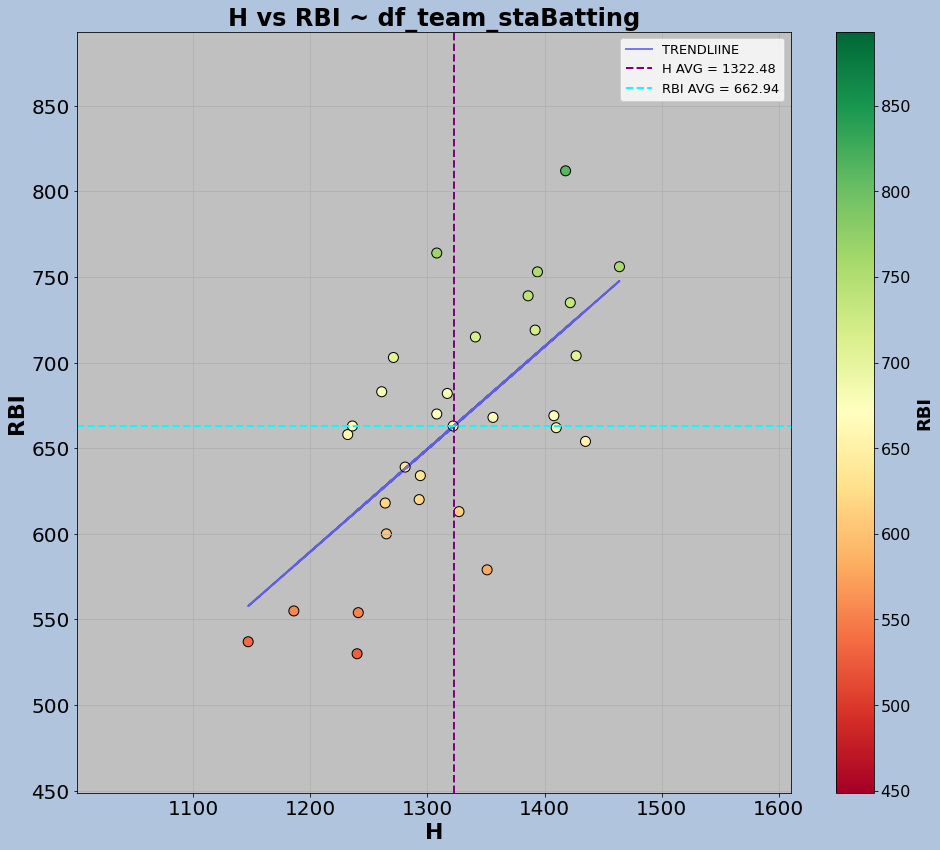


Season Trend Line Equation: y = 0.598971x + (-129.194322)

R-squared: 0.4650538859847274

                            OLS Regression Results                            
Dep. Variable:                    RBI   R-squared:                       0.465
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     25.21
Date:                Wed, 01 Feb 2023   Prob (F-statistic):           2.39e-05
Time:                        11:01:29   Log-Likelihood:                -165.39
No. Observations:                  31   AIC:                             334.8
Df Residuals:                      29   BIC:                             337.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [38]:
def stat_reg_analysis(df, statx, staty, cbar_rev=False):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 14))
    df_new = df.copy()
    
    try: df_new = df_new[df_new.Tm != 'League Totals']
    except: pass
    
    x=pd.to_numeric(df_new[statx]).fillna(0)
    y=pd.to_numeric(df_new[staty]).fillna(0)
    
    initial_cmap = cm.get_cmap('RdYlGn')
    reversed_cmap=initial_cmap.reversed()

    # Calc the season trendline
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x), label='TRENDLIINE', linestyle = 'solid', alpha=0.5, color='blue', linewidth=2)
    
    # Change s size based on frequency???

    if cbar_rev:
        plt.scatter(x,y, c=y, cmap=reversed_cmap, s=100, edgecolor='black')
    else:
        plt.scatter(x,y, c=y, cmap=initial_cmap, s=100, edgecolor='black')

    plt.axvline(x.mean(), label=f"{statx} AVG = {round(x.mean(),2)}", linestyle='dashed', color='purple', linewidth=2)
    plt.axhline(y.mean(), label=f"{staty} AVG = {round(y.mean(),2)}", linestyle='dashed', color='cyan', linewidth=2)
    
    xmin = x.min()-(x.max()*.1)
    ymin = y.min()-(y.max()*.1)
    
    xmax = x.max()+(x.max()*.1)
    ymax = y.max()+(y.max()*.1)

    plt.xlabel(statx, fontsize=22, fontweight='bold')
    plt.ylabel(staty, fontsize=22, fontweight='bold')
    
    plt.legend(loc='best', prop={'weight':'bold', 'size':14})

    ax.set_facecolor('silver')
    fig.set_facecolor('lightsteelblue')
    fig.set_edgecolor('black')

    plt.title(f'{statx} vs {staty} ~ {get_df_name(df)}', fontsize=24, fontweight='bold')
    
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.clim(ymin,ymax)
    
    cbar = plt.colorbar(cmap='RdYlGn')

    cbar.ax.tick_params(labelsize=16)
    cbar.set_label(label=staty, size=18, weight='bold')
    
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    plt.legend(loc='best', fontsize=13)
    plt.grid()
    plt.show()

    print()
    print(color.BOLD +'Season Trend Line Equation: ' + color.END + "y = %.6fx + (%.6f)"%(z[0],z[1]))

    # Calc R-squared
    model = LinearRegression()
    model.fit(x.values.reshape(-1, 1), y)
    r_squared = model.score(x.values.reshape(-1, 1), y)
    print()
    print(color.BOLD + "R-squared: "+ color.END + str(r_squared))
    print()
    
    lm = smf.ols(formula = f'{staty} ~ {statx}', data=df_new).fit()
    print(lm.summary())

stat_reg_analysis(df_team_staBatting, 'H','RBI', cbar_rev=False)

### 3D Scatter Plot Function

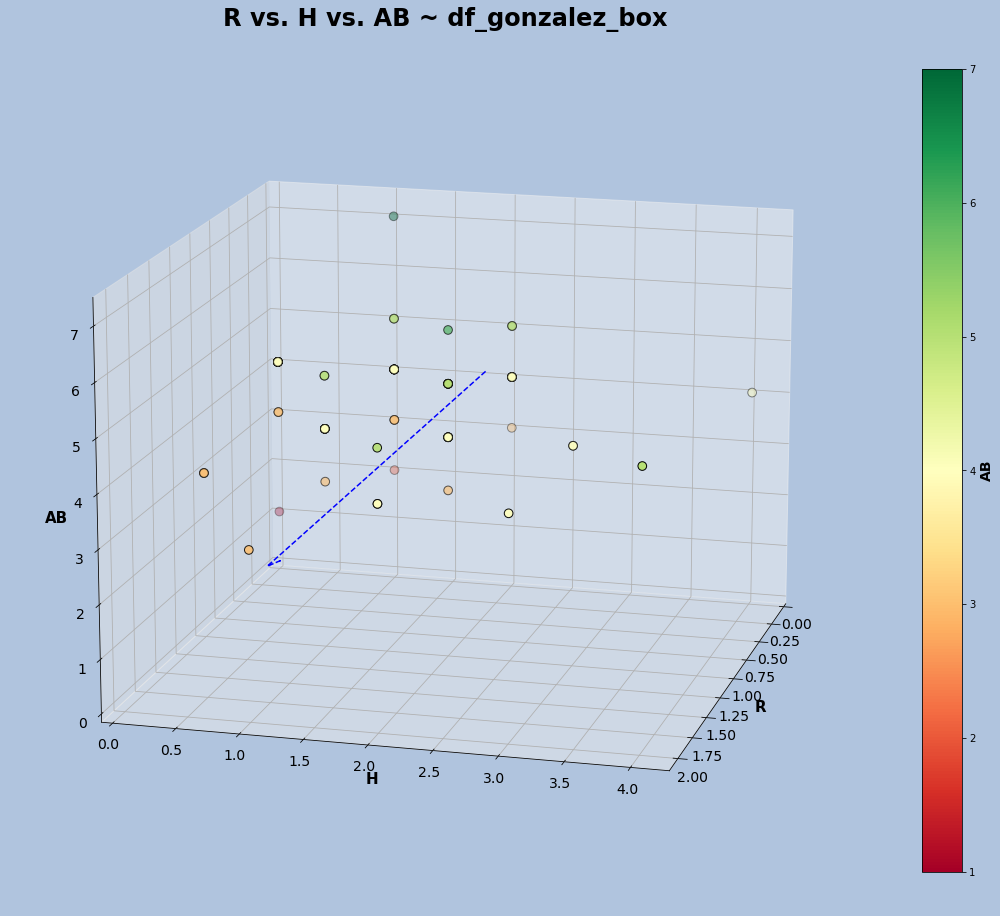

In [27]:
def scatter_3d(df,x,y,z, xview=15, yview=15,zview=0, sv_anim=False):
    initial_cmap = cm.get_cmap('RdYlGn')
    reversed_cmap=initial_cmap.reversed()
    
    fig = plt.figure(figsize=(14, 14))
    ax = fig.add_subplot(projection='3d')
    
    ax.set_facecolor('lightsteelblue')
    fig.set_facecolor('lightsteelblue')
    
    ax.set_xlabel(x, fontweight='bold', fontsize=15)
    ax.set_ylabel(y, fontweight='bold', fontsize=15)
    ax.set_zlabel(z, fontweight='bold', fontsize=15)
    
    xdata=df[x].fillna(0)
    ydata=df[y].fillna(0)
    zdata=df[z].fillna(0)
    
    # Function to create s value base on the 3 values
    
    sc = ax.scatter(xdata,ydata,zdata,c=zdata, cmap=initial_cmap, edgecolor='black', s=75)

    cbar = fig.colorbar(sc, ax=ax, fraction=0.042, pad=0.04)
    cbar.set_label(z, fontsize=14, fontweight='bold')
    
    t = np.arange(df.shape[0])

    fitx = np.polyfit(t, xdata, 4)
    fity = np.polyfit(t, ydata, 4)
    fitz = np.polyfit(t, zdata, 4)

    ax.plot(fitx,fity,fitz, color='blue', linestyle='dashed')
    
    plt.xlim(0,None)
    plt.ylim(0,None)
    ax.set_zlim(0,None)
    
    plt.title(f'{x} vs. {y} vs. {z} ~ {get_df_name(df)}', fontweight='bold', fontsize=24)
    plt.grid()
    plt.tight_layout()
    
    ax.view_init(xview,yview,zview)
    
    for t in ax.xaxis.get_major_ticks(): t.label1.set_fontsize(14)
    for t in ax.yaxis.get_major_ticks(): t.label1.set_fontsize(14)
    for t in ax.zaxis.get_major_ticks(): t.label1.set_fontsize(14)
        
    if sv_anim:
        
        def init():
            ax.view_init(elev=15., azim=0)
            return [sc]
        
        def animate(i):
            ax.view_init(elev=15., azim=i)
            return [sc]
        
        ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)
        
        plt.show()
        
        try: os.mkdir('C:\\Users\\Peter\\NBA_3D_Scatter_Anims')
        except: pass
        
        try: ani.save(f'C:\\Users\\Peter\\NBA_3D_Scatter_Anims\\{x}_{y}_{z}.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
        except: pass
        
    
    else:
        plt.show()
        
scatter_3d(df_gonzalez_box,'R','H','AB', sv_anim=False)

# Go to save location to view animation
# TODO: Display animation, currently having issues, but saved video is available

### Team Stat Leaders Bar Chart Function

In [28]:
def team_leaders(df, stat, pal, num=10):
    
    try: df_new = df[df.Tm != 'League Totals']
    except: pass
    
    
    if num<=10: figheight=num
    if num>10 and num>=20: figheight=num*0.9
    if num>20 and num>=30: figheight=num*0.8
    if num>30 and num>=40: figheight=num*0.7
    if num>40 and num>=50: figheight=num*0.6
    if num>50: figheight=num*0.5
        
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, figheight))
    
    x = df_new.sort_values(f'{stat}',ascending=False).reset_index(drop=True).head(num).sort_values(f'{stat}',ascending=True).Tm
    y = df_new.sort_values(f'{stat}',ascending=False).reset_index(drop=True).head(num).sort_values(f'{stat}',ascending=True)[f'{stat}']
    
    my_cmap = plt.get_cmap(f"{pal}")
    rescale = lambda y: (y*1.03 - np.min(y))/ (np.max(y) - np.min(y))
    
    ax.barh(x,y,color=my_cmap(rescale(y)), edgecolor='black')
    if y.min()>1: ax.bar_label(ax.containers[0], fontsize=16, fontweight='bold', fmt = '%.0f', color='black')
    else: ax.bar_label(ax.containers[0], fontsize=16, fontweight='bold', fmt = '%.3f', color='black')
        
    plt.xticks(fontsize=18, fontweight='bold', color='black')
    plt.xlabel(f'{stat}', fontsize=22, fontweight='bold', color='black')

    plt.yticks(fontsize=16, fontweight='bold', color='black')
    
    plt.title(f"{stat} LEADERS", fontsize=26, fontweight='bold', color='black')
    
    ax.set_facecolor('lightgrey')
    fig.set_facecolor(my_cmap(0))
    
    plt.show()

### 2022 Team Hitting Leaders

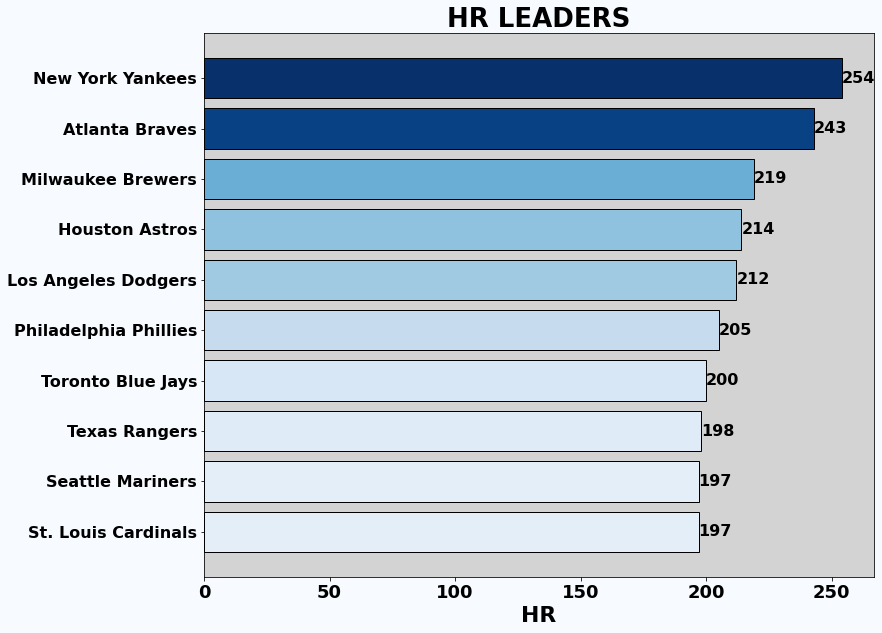

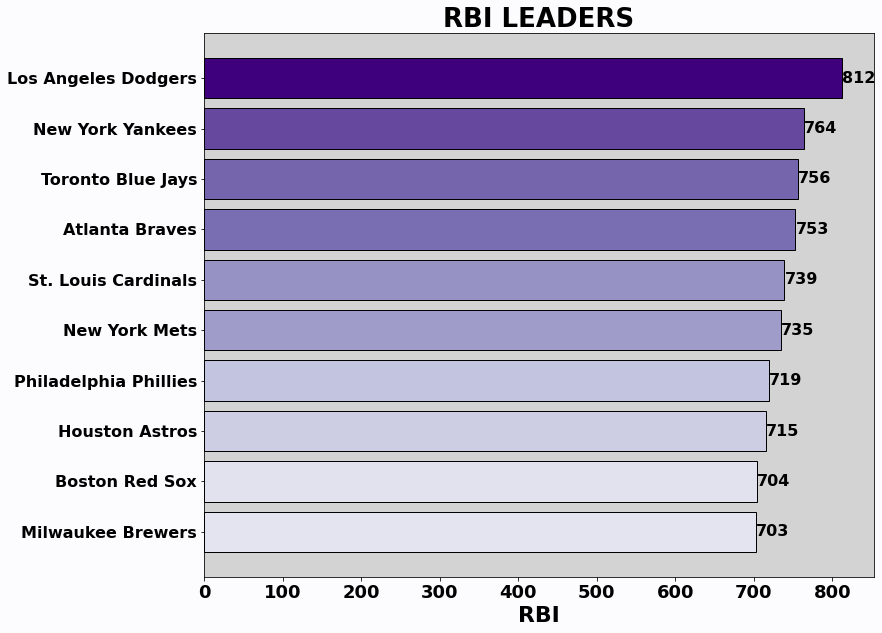

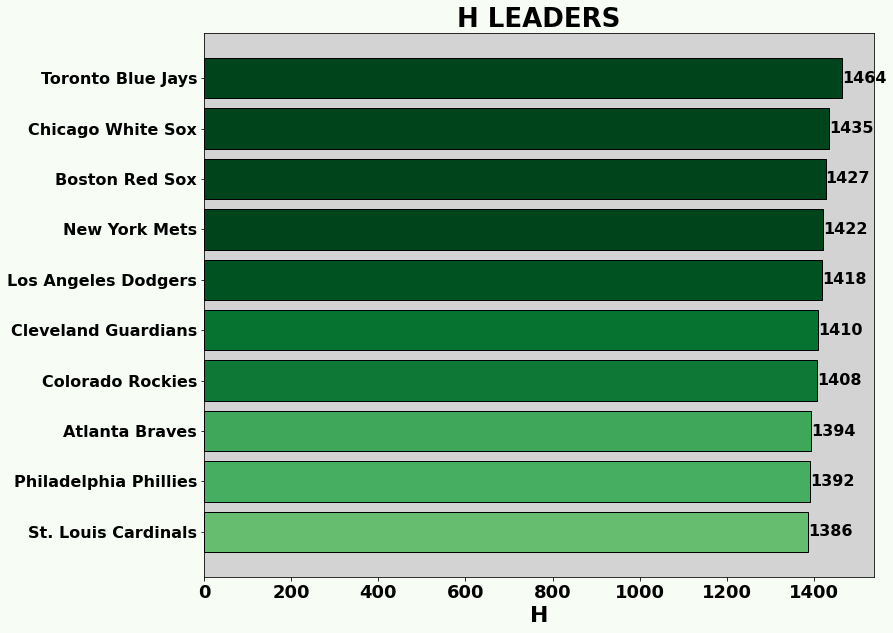

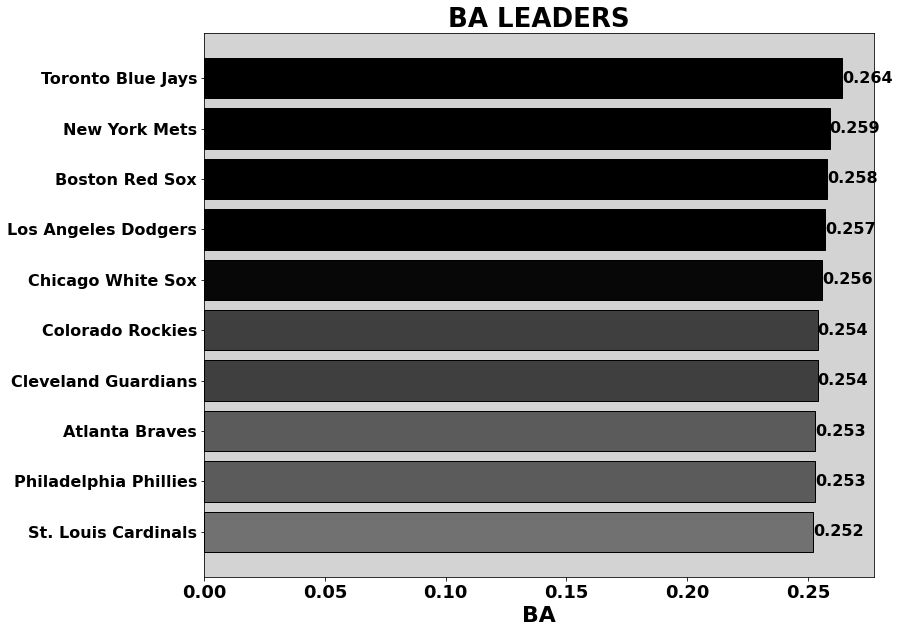

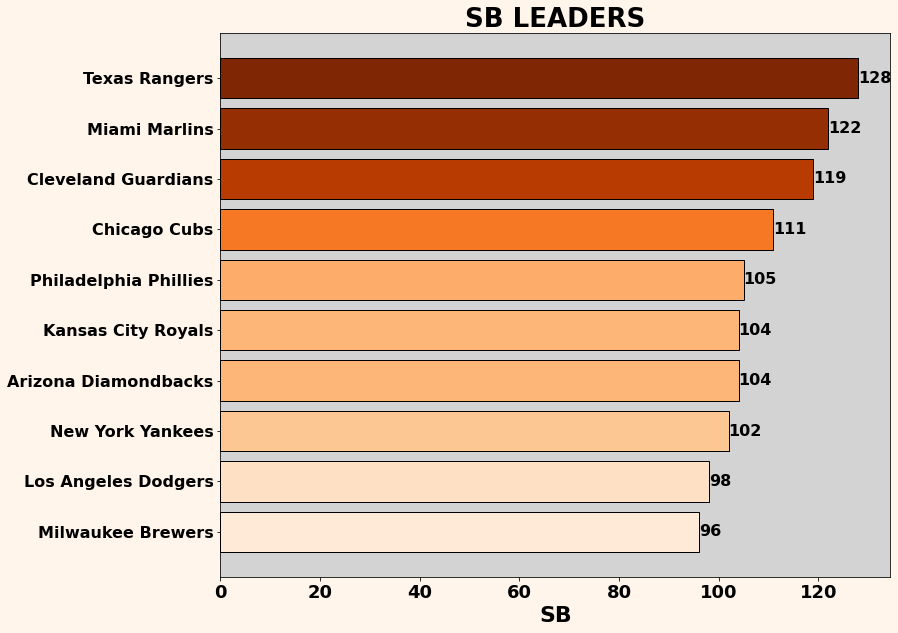

In [29]:
team_leaders(df_team_staBatting,'HR','Blues', num=10)
team_leaders(df_team_staBatting,'RBI','Purples', num=10)
team_leaders(df_team_staBatting,'H','Greens', num=10)
team_leaders(df_team_staBatting,'BA','Greys', num=10)
team_leaders(df_team_staBatting,'SB','Oranges', num=10)

### 2022 Team Pitching Leaders

### Statistical Distibution histogram function

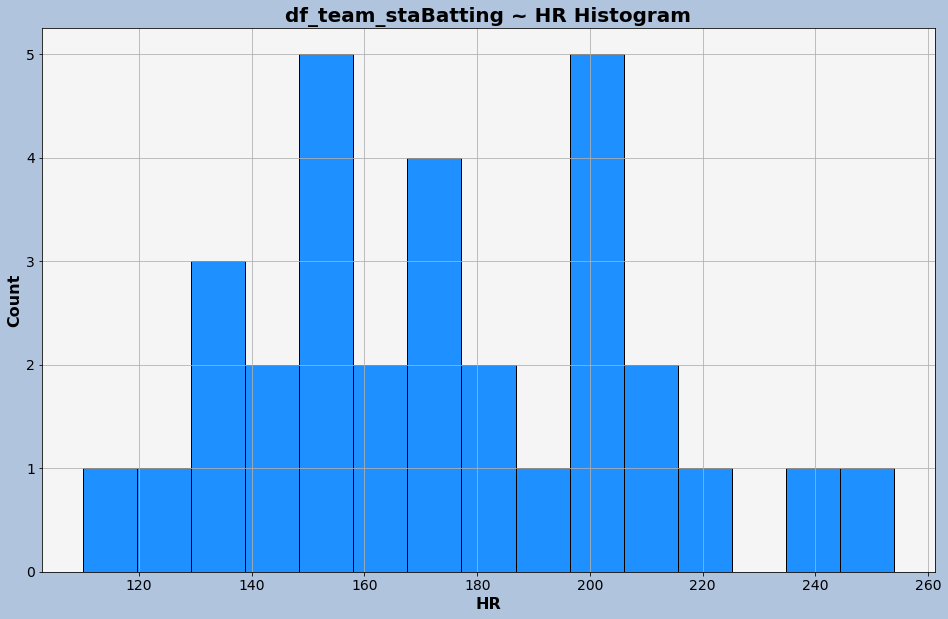

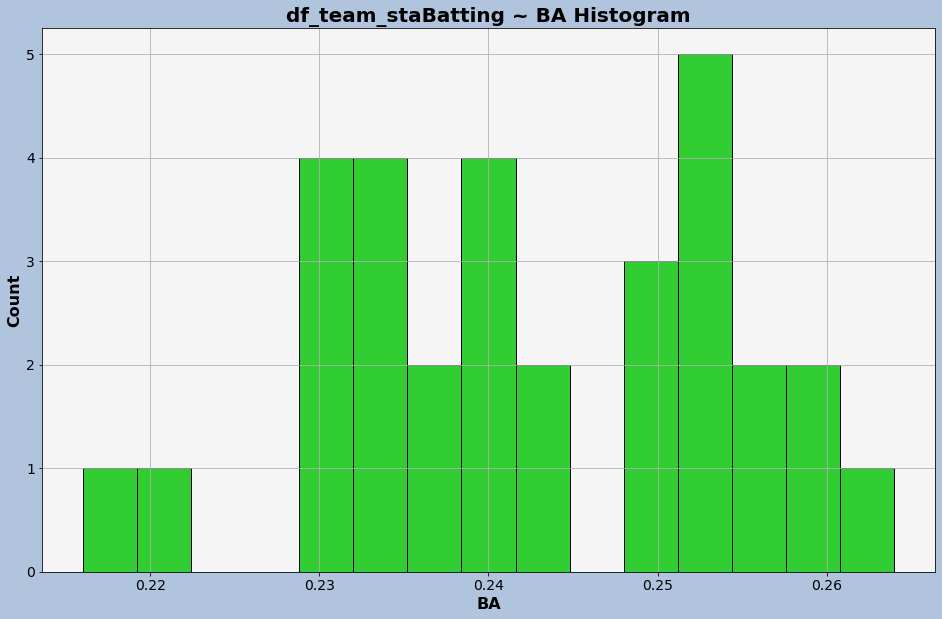

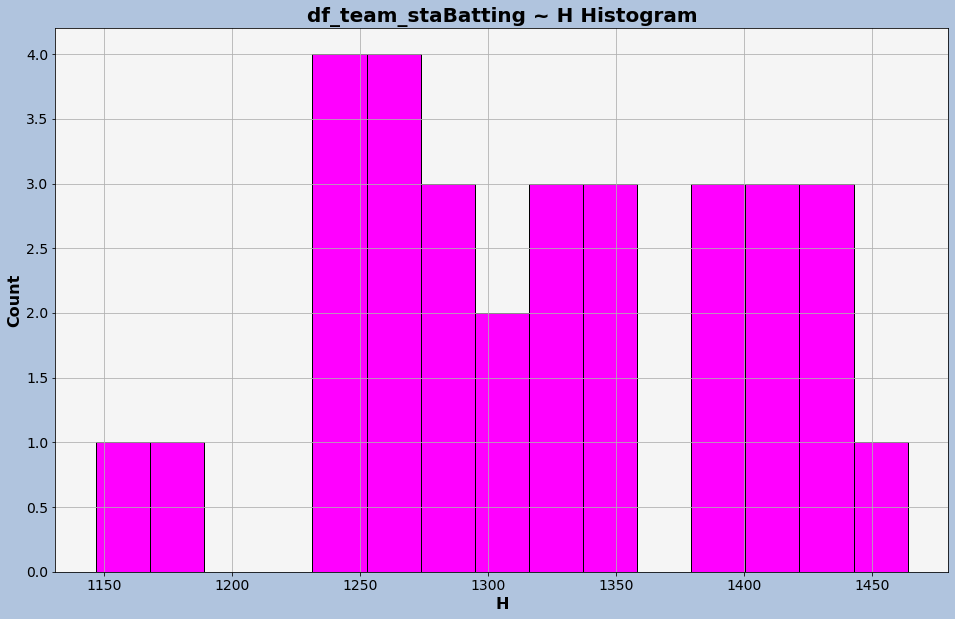

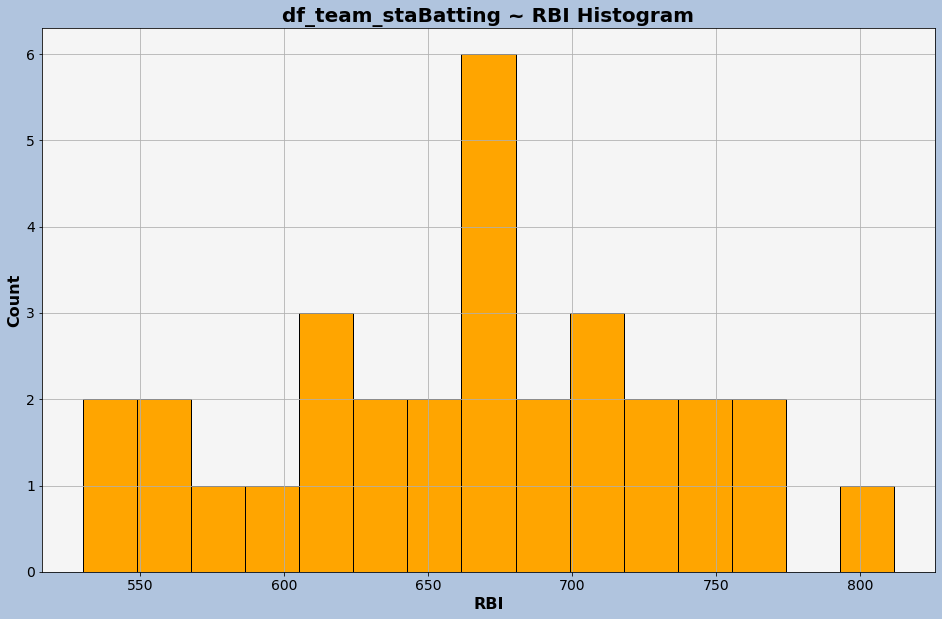

In [30]:
def stat_hist(df, stat, bins=15, color='royalblue'):
    
    def get_df_name(df):
        name =[x for x in globals() if globals()[x] is df][0]
        return name
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))
    
    try: dist = df[df.Tm != 'League Totals'][stat]
    except: dist=df[stat]

    ax.hist(dist, bins=bins, color=color, edgecolor='black')
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.ylabel('Count', fontsize=16, fontweight='bold')
    plt.xlabel(stat, fontsize=16, fontweight='bold')
    
    plt.title(f'{get_df_name(df)} ~ {stat} Histogram', fontsize=20, fontweight='bold')
    ax.set_facecolor('whitesmoke')
    fig.set_facecolor('lightsteelblue')
    plt.grid()
    plt.show()
    
stat_hist(df_team_staBatting, 'HR', color='dodgerblue')
stat_hist(df_team_staBatting, 'BA', color='limegreen')
stat_hist(df_team_staBatting, 'H', color='magenta')
stat_hist(df_team_staBatting, 'RBI', color='orange')

## Statistical Distribution KDE Function

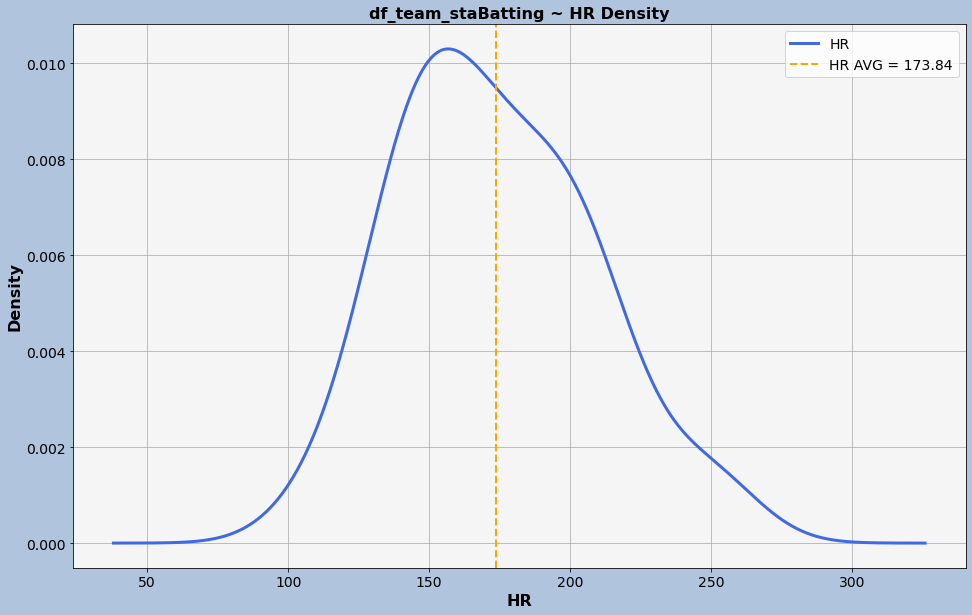

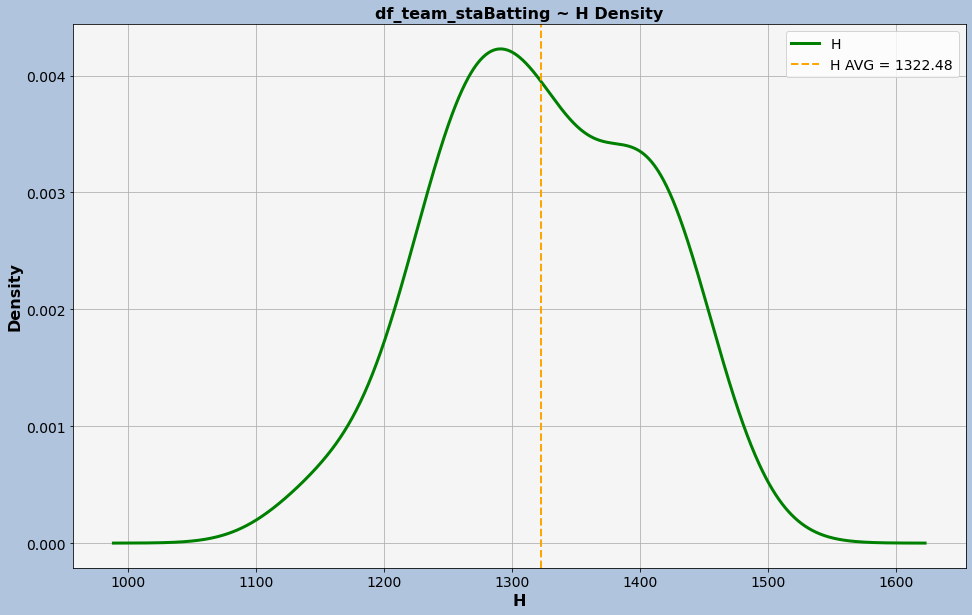

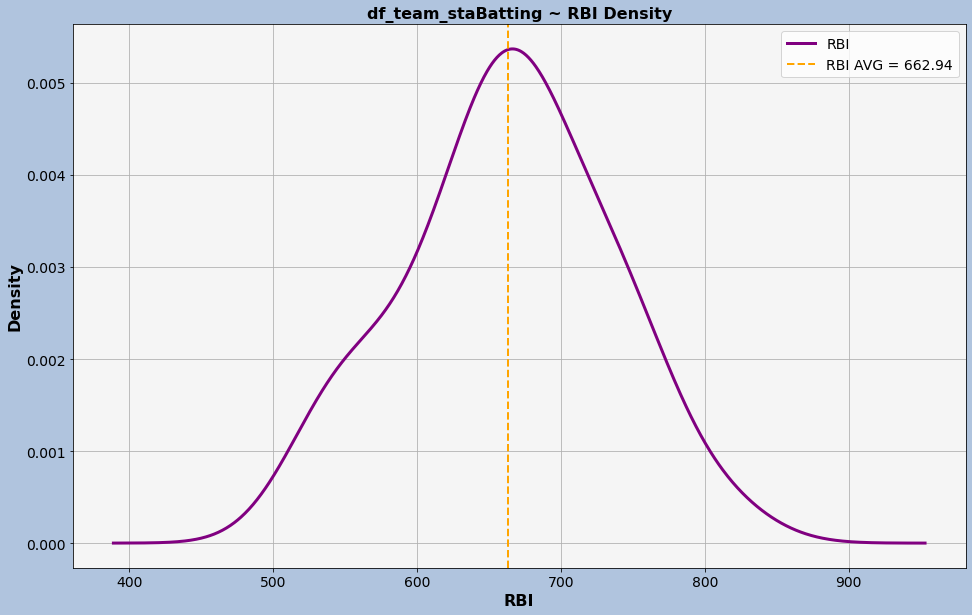

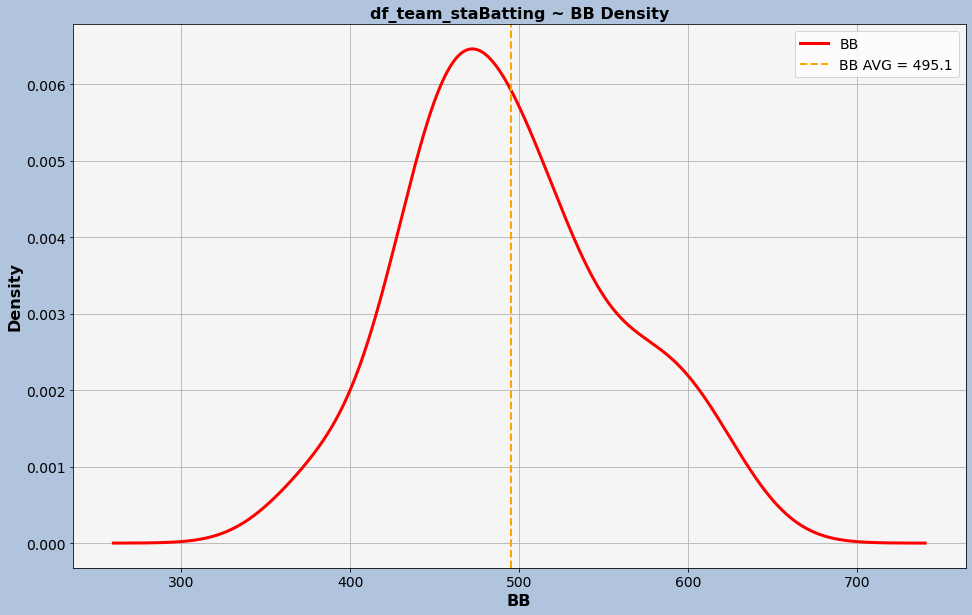

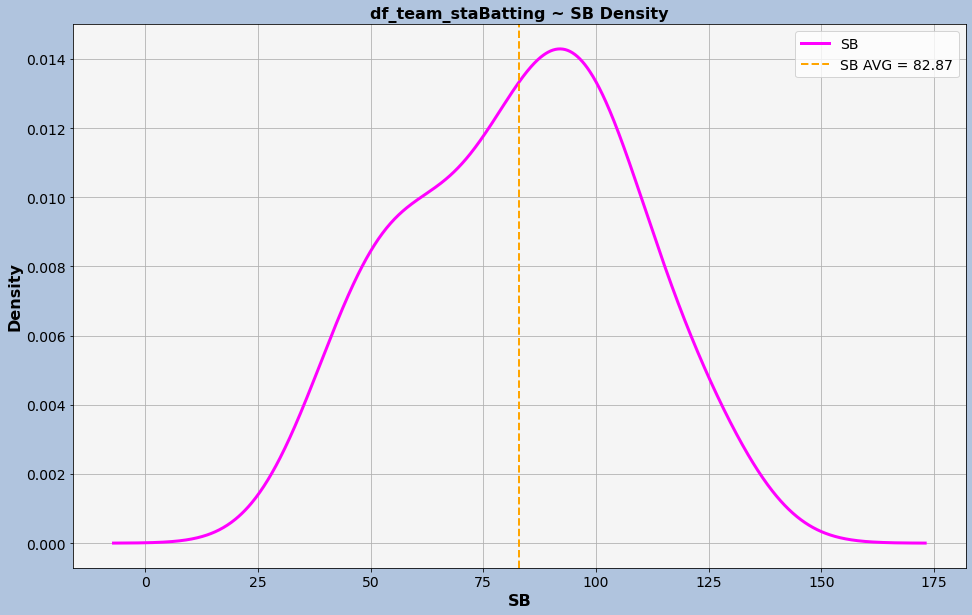

In [31]:
def team_stat_kde_compare(df, stat, color='royalblue'):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))
    
    plt.xlabel(stat, fontweight='bold', fontsize=16)
    plt.ylabel('Density', fontweight='bold', fontsize=16)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    try: dist = df[df.Tm != 'League Totals'][stat]
    except: dist=df[stat]

    dist.plot.kde(color=color, linewidth=3)
    
    plt.axvline(dist.mean(), label=f"{stat} AVG = {round(dist.mean(),2)}", linestyle='dashed', color='orange', linewidth=2)


    plt.title(f'{get_df_name(df)} ~ {stat} Density', fontsize=16, fontweight='bold')
    plt.legend(loc='best', fontsize=14)
    ax.set_facecolor('whitesmoke')
    fig.set_facecolor('lightsteelblue')
    plt.grid()
    plt.show()
    
team_stat_kde_compare(df_team_staBatting, 'HR')
team_stat_kde_compare(df_team_staBatting, 'H', color='green')
team_stat_kde_compare(df_team_staBatting, 'RBI', color='purple')
team_stat_kde_compare(df_team_staBatting, 'BB', color='red')
team_stat_kde_compare(df_team_staBatting, 'SB', color='Magenta')